# Latent Consistency Model using Optimum-Intel OpenVINO
This notebook provides instructions how to run Latent Consistency Model (LCM). It allows to setup standard Hugging Face diffusers pipeline and Optimum Intel pipeline optimized for Intel hardware including CPU and GPU. Running inference on CPU and GPU it is easy to compare performance and time required to generate an image for provided prompt. The notebook can be also used on other Intel hardware with minimal or no modifications.  

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/1858dae4-72fd-401e-b055-66d503d82446)

Optimum Intel is an interface from Hugging Face between both diffusers and transformers libraries and various tools provided by Intel to accelerate pipelines on Intel hardware. It allows to perform quantization of the models hosted on Hugging Face.
In this notebook OpenVINO is used for AI-inference acceleration as a backend for Optimum Intel! 

For more details please refer to Optimum Intel repository
https://github.com/huggingface/optimum-intel

<img src="https://github.com/openvinotoolkit/openvino_notebooks/assets/105707993/a668529a-e1bd-46c6-9be4-1e6ca705c939"/>


LCMs are the next generation of generative models after Latent Diffusion Models (LDMs). They are proposed to overcome the slow iterative sampling process of Latent Diffusion Models (LDMs), enabling fast inference with minimal steps (from 2 to 4) on any pre-trained LDMs (e.g. Stable Diffusion). To read more about LCM please refer to https://latent-consistency-models.github.io/

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Full precision model on the CPU](#Using-full-precision-model-in-CPU-with-LatentConsistencyModelPipeline)
- [Running inference using Optimum Intel `OVLatentConsistencyModelPipeline`](#Running-inference-using-Optimum-Intel-OVLatentConsistencyModelPipeline)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/latent-consistency-models-image-generation/latent-consistency-models-optimum-demo.ipynb" />


### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages

In [1]:
%pip install -q "openvino>=2023.3.0"
%pip install -q "onnx>=1.11.0,<1.16.2"
%pip install -q "optimum-intel[diffusers]@git+https://github.com/huggingface/optimum-intel.git" "ipywidgets" "torch>=2.1" "transformers>=4.33.0" --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings

warnings.filterwarnings("ignore")

### Showing Info Available Devices
[back to top ⬆️](#Table-of-contents:)

The `available_devices` property shows the available devices in your system. The "FULL_DEVICE_NAME" option to `ie.get_property()` shows the name of the device. Check what is the ID name for the discrete GPU, if you have integrated GPU (iGPU) and discrete GPU (dGPU), it will show `device_name="GPU.0"` for iGPU and `device_name="GPU.1"` for dGPU. If you just have either an iGPU or dGPU that will be assigned to `"GPU"`

Note: For more details about GPU with OpenVINO visit this [link](https://docs.openvino.ai/2024/get-started/configurations/configurations-intel-gpu.html). If you have been facing any issue in Ubuntu 20.04 or Windows 11 read this [blog](https://blog.openvino.ai/blog-posts/install-gpu-drivers-windows-ubuntu).

In [3]:
import openvino as ov
import openvino.properties as props


core = ov.Core()
devices = core.available_devices

for device in devices:
    device_name = core.get_property(device, props.device.full_name)
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) Ultra 7 155H
GNA.GNA_SW: GNA_SW
GNA.GNA_HW: GNA_HW
GPU: Intel(R) Arc(TM) Graphics (iGPU)
NPU: Intel(R) AI Boost


### Using full precision model in CPU with `LatentConsistencyModelPipeline`
[back to top ⬆️](#Table-of-contents:)

Standard pipeline for the Latent Consistency Model(LCM) from Diffusers library is used here. For more information please refer to  https://huggingface.co/docs/diffusers/en/api/pipelines/latent_consistency_models


In [4]:
from diffusers import LatentConsistencyModelPipeline
import gc

pipeline = LatentConsistencyModelPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

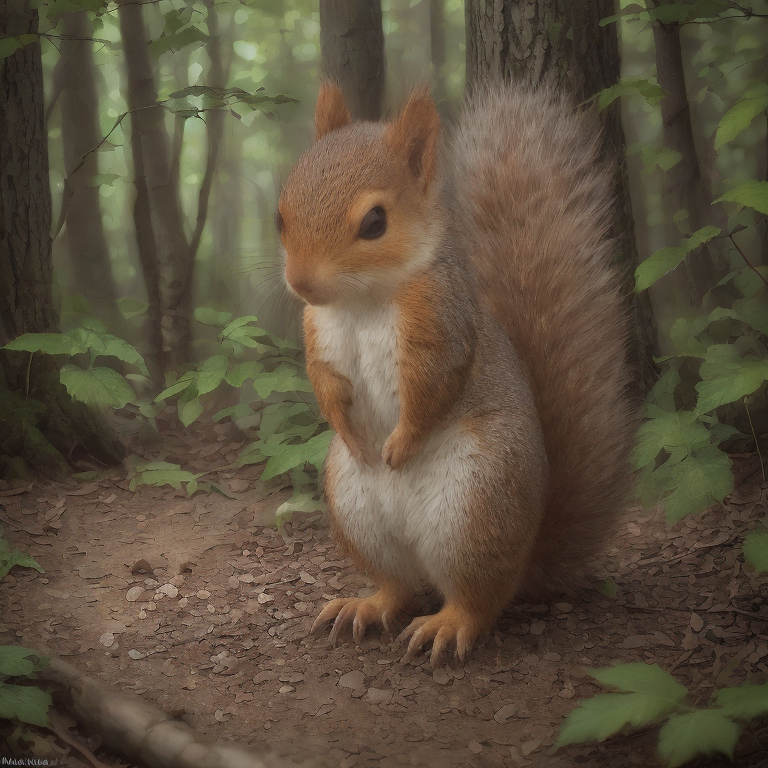

In [6]:
prompt = "A cute squirrel in the forest, portrait, 8k"

image = pipeline(prompt=prompt, num_inference_steps=4, guidance_scale=8.0, height=512, width=512).images[0]
image.save("image_standard_pipeline.png")
image

In [7]:
del pipeline
gc.collect();

345

### Select inference device for text-to-image generation

In [ ]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

### Running inference using Optimum Intel `OVLatentConsistencyModelPipeline`
[back to top ⬆️](#Table-of-contents:)

Accelerating inference of LCM using Intel Optimum with OpenVINO backend. For more information please refer to https://huggingface.co/docs/optimum/intel/inference#latent-consistency-models. 
The pretrained model in this notebook is available on Hugging Face in FP32 precision and in case if CPU is selected as a device, then inference runs with full precision. For GPU accelerated AI-inference is supported for FP16 data type and FP32 precision for GPU may produce high memory footprint and latency. Therefore, default precision for GPU in OpenVINO is FP16. OpenVINO GPU Plugin converts FP32 to FP16 on the fly and there is no need to do it manually

In [ ]:
from optimum.intel.openvino import OVLatentConsistencyModelPipeline
from pathlib import Path

if not Path("./openvino_ir").exists():
    ov_pipeline = OVLatentConsistencyModelPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7", height=512, width=512, export=True, compile=False)
    ov_pipeline.save_pretrained("./openvino_ir")
else:
    ov_pipeline = OVLatentConsistencyModelPipeline.from_pretrained("./openvino_ir", export=False, compile=False)

ov_pipeline.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)

In [ ]:
ov_pipeline.to(device.value)
ov_pipeline.compile()

  0%|          | 0/4 [00:00<?, ?it/s]

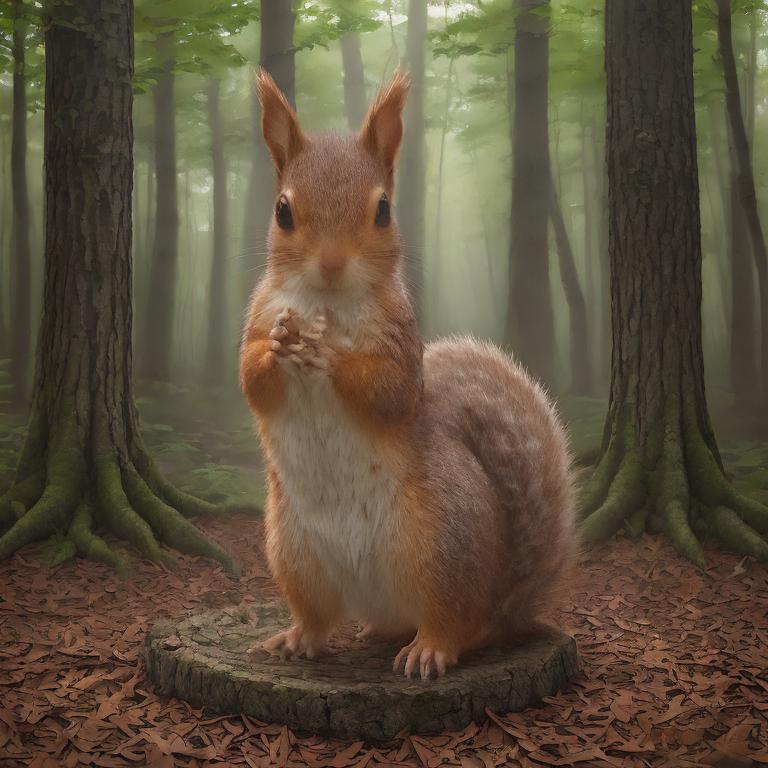

In [12]:
prompt = "A cute squirrel in the forest, portrait, 8k"

image_ov = ov_pipeline(prompt=prompt, num_inference_steps=4, guidance_scale=8.0, height=512, width=512).images[0]
image_ov.save("image_opt.png")
image_ov

In [ ]:
del ov_pipeline
gc.collect();